# Data Preprocessing and Exploratory Data Analysis


Import the necessary packages

In [1]:
import pandas as pd
import tqdm 
import numpy as np 

import nltk 
import re
import gensim

import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from praw.models import MoreComments

from sklearn.pipeline import Pipeline, FeatureUnion
import skipthoughts


In [2]:
df_india = pd.read_csv('clean_reddit_india.csv')
df_india.head()

,Unnamed: 0,Unnamed: 0.1,title,score,id,url,num_comments,body,created,Comment,Flair,new_feature
0,0,0,"['untouchability', 'even', 'quarantine', 'neve...",58,fzvwz8,['httpswwwtelegraphindiacomindiacoronavirusout...,6,['nan'],1.586723e+09,"['let', 'feel', 'hungry', 'couple', 'day', 'ma...",Scheduled,"['untouchability', 'even', 'quarantine', 'neve..."
1,1,1,"['delhi', 'govt', 'source', 'name', 'cm', 'arv...",304,f7ogd8,['httpstwittercomanistatus1231093900518932480s...,30,['nan'],1.582380e+09,"['beyond', 'petty', 'inclusion', 'delhi', 'gov...",Scheduled,"['delhi', 'govt', 'source', 'name', 'cm', 'arv..."
2,2,2,"['delhi', 'ap', 'singh', 'advocate', '2012', '...",16,flgvah,['httpstwittercomanistatus1240731289075871744s...,19,['nan'],1.584678e+09,"['hunch', 'guy', 'trying', 'expose', 'loophole...",Scheduled,"['delhi', 'ap', 'singh', 'advocate', '2012', '..."
3,3,3,"['100', 'quota', 'tribal', 'teacher', 'school'...",18,g698qu,['httpswwwthehinducomnewsnationalno100quotafor...,2,['nan'],1.587618e+09,"['sc', 'point', '100', 'quota', 'ok', 'thats',...",Scheduled,"['100', 'quota', 'tribal', 'teacher', 'school'..."
4,4,4,"['supreme', 'court', '’', 'verdict', 'scst', '...",105,f1o839,['httpsscrollinarticle952687whythesupremecourt...,47,['nan'],1.581358e+09,"['muslim', 'reservation', 'two', 'distraction'...",Scheduled,"['supreme', 'court', '’', 'verdict', 'scst', '..."


In [3]:
    print(df_india.columns)
    df_india.drop(columns=['Unnamed: 0'], inplace=True)
    df_india = df_india.rename(columns={'Unnamed: 0.1':'Index'})


Index(['Unnamed: 0', 'Unnamed: 0.1', 'title', 'score', 'id', 'url',
       'num_comments', 'body', 'created', 'Comment', 'Flair', 'new_feature'],
      dtype='object')


We use label encoding in order to convert our string like labels to integers for training

Also store the keys, which will be used later in the project

In [4]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_india['Flair_cat'] = le.fit_transform(df_india['Flair'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

print(le_name_mapping)
with open('pickles/le_dict.pkl', 'wb') as f:
    pickle.dump(le_name_mapping, f)


{'AskIndia': 0, 'Business/Finance': 1, 'CAA-NRC-NPR': 2, 'Coronavirus': 3, 'Food': 4, 'Non-Political': 5, 'Photography': 6, 'Politics': 7, 'Scheduled': 8, 'Science/Technology': 9, 'Sports': 10}


In [5]:
df_india['Flair_cat'].value_counts()


9     200
7     200
5     200
3     200
1     200
10    200
8     200
6     200
4     200
0     200
2     107
Name: Flair_cat, dtype: int64

In [6]:
df_india.columns


Index(['Index', 'title', 'score', 'id', 'url', 'num_comments', 'body',
       'created', 'Comment', 'Flair', 'new_feature', 'Flair_cat'],
      dtype='object')

Split into train and test set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_india['new_feature'],
                                                    df_india['Flair_cat'],
                                                    test_size=0.2)

# TF-IDF Vectorizer
TF-IDF is a score that represents the relative importance of a term in the
document and the entire corpus. TF stands for Term Frequency, and IDF stands for
Inverse Document Frequency:

The TFIDF value increases proportionally to the number of times a word appears in
the document and is offset by the number of documents in the corpus that contain
the word, which helps to adjust for the fact that some words appear more
frequently in general.
It also takes into account the fact that some documents may be larger than others
by normalizing the TF term (expressing instead relative term frequencies)

We have chosen TF-IDF vectors to represent the documents in our corpus. This
election is motivated by the following points:
1)  TF-IDF is a simple model that yields great results in this particular domain.

2)  TF-IDF features creation is a fast process, which will lead us to shorter
    waiting time for the user when using the web application.

3)  We can tune the feature creation process (see next paragraph) to avoid
    issues like overfitting.

# The parameters we can tune are:
N-gram 4 range: we are able to consider unigrams, bigrams, trigrams...

Maximum/Minimum Document Frequency: when building the vocabulary,
we can ignore terms that have a document frequency strictly higher/lower
than the given threshold

Maximum features: we can choose the top N features ordered by term
frequency across the corpus. We do not define this in order to have our corpus as large as possible to improve generality

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', 
        encoding='latin-1', ngram_range=(1, 2), stop_words='english')

In [9]:
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(1685, 3207)
(422, 3207)


# Chi square analysis and unigrams/bigrams

We use chi-square analysis to find the most relavant unigrams and bigrams for each category.

As we can see and conclude with domain knowledge the results are relevant

In [10]:
from sklearn.feature_selection import chi2
import numpy as np

column_values = df_india['Flair_cat'].values
flair_list = pd.unique(column_values)

N = 5
for flair_cat in sorted(flair_list):
    print(flair_cat)
    features_chi2 = chi2(features_train, labels_train==flair_cat)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [word for word in feature_names if len(word.split(' '))==1]
    bigrams = [word for word in feature_names if len(word.split(' '))==2]
    flair = df_india.loc[lambda df_india:df_india['Flair_cat']==flair_cat]
    print(" '{}':".format(flair['Flair'].iloc[0]))
    print("Most correlated unigrams: \n{}".format('\n'.join(unigrams[-N:])))
    print("Most correlated bigrams: \n{}".format('\n'.join(bigrams[-N:])))

0
 'AskIndia':
Most correlated unigrams: 
loose
flat
bribe
aunty
askindia
Most correlated bigrams: 
indian society
video game
pretty good
credit card
dont use
1
 'Business/Finance':
Most correlated unigrams: 
bank
2016
ending
business
finance
Most correlated bigrams: 
indian startup
indian economy
economy week
week ending
week indian
2
 'CAA-NRC-NPR':
Most correlated unigrams: 
caanprnrc
protest
caa
nrc
npr
Most correlated bigrams: 
nrc caa
npr nrc
caa nrc
caa npr
nrc npr
3
 'Coronavirus':
Most correlated unigrams: 
lockdown
tested
test
testing
coronavirus
Most correlated bigrams: 
coronavirus patient
coronavirus nan
coronavirus pandemic
coronavirus lockdown
coronavirus case
4
 'Food':
Most correlated unigrams: 
rice
cooking
lockdown
delivery
food
Most correlated bigrams: 
provide food
indian food
food supply
free food
food delivery
5
 'Non-Political':
Most correlated unigrams: 
celebrating
fir
political
non
nonpolitical
Most correlated bigrams: 
check readme
im bot
year old
nonpolitic

# Box plot for length

Text(0.5, 1.0, 'Length')

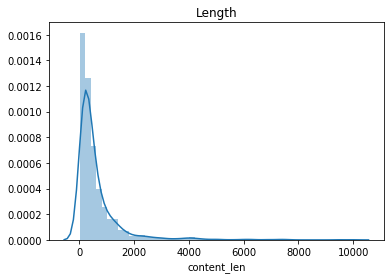

In [11]:
df_india['content_len'] = df_india['new_feature'].str.len()
sns.distplot(df_india['content_len']).set_title('Length')


In [12]:
df_india['content_len'].describe()


count    2107.000000
mean      624.125297
std       879.598251
min        27.000000
25%       183.000000
50%       349.000000
75%       693.000000
max      9987.000000
Name: content_len, dtype: float64

Plot without instances whose quantile is >95 with hopes of using length as an attribute for training

In [13]:
quantile_95 = df_india['content_len'].quantile(0.95)
df_95 = df_india[df_india['content_len']<quantile_95]


Text(0.5, 1.0, 'Length')

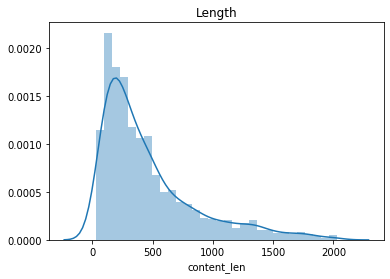

In [14]:
sns.distplot(df_95['content_len']).set_title('Length')


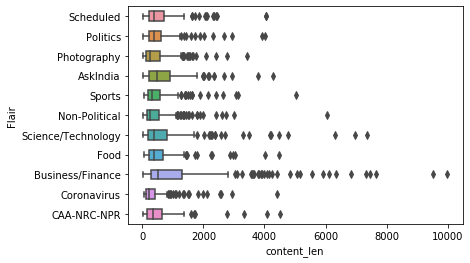

In [15]:
sns.boxplot(data=df_india, x='content_len', y='Flair', width=.5)


Despite some difference in the length category wise, there is not enough variance to use this as a feature, hence discarded

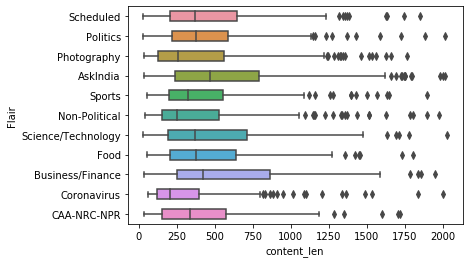

In [16]:
sns.boxplot(data=df_95, x='content_len', y='Flair', width=.5)

# Word Cloud
Word clouds are a method for visually presenting text data. They are popular for text analysis because they make it easy to spot word frequencies. The more frequent the work is used, the larger and bolder it is displayed.

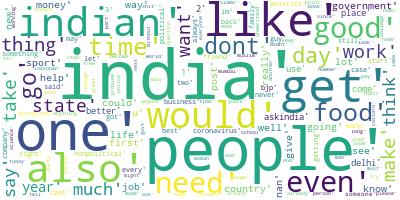

In [17]:
from wordcloud import WordCloud
long_string = ','.join(df_95['new_feature'].values)
wc = WordCloud(background_color="white",
               max_words=5000, contour_width=3,
               contour_color='steelblue')

wc.generate(long_string)
wc.to_image()

Write to necessary files as pickles 

In [18]:
with open('pickles/clean_95.pkl', 'wb') as f:
    pickle.dump(df_95, f)

with open('pickles/df.pkl', 'wb') as f:
    pickle.dump(df_india, f)

with open('pickles/X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)

with open('pickles/X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)

with open('pickles/y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)

with open('pickles/y_test.pkl', 'wb') as f:
    pickle.dump(X_train, f)

with open('pickles/tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

with open('pickles/features_train.pkl', 'wb') as f:
    pickle.dump(features_train, f)

with open('pickles/features_test.pkl', 'wb') as f:
    pickle.dump(features_test, f)

with open('pickles/labels_train.pickle', 'wb') as f:
    pickle.dump(labels_train, f)

with open('pickles/labels_test.pkl', 'wb') as f:
    pickle.dump(labels_test, f)